## Gradients

$\pi$


$\pi$

cs231n.github.io/neural-networks-3/


In [1]:
from math import sin, cos
import matplotlib.pyplot as plt
import numpy as np
#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
@np.vectorize
def any_function(x):
    return (x)**2 + 3*sin(x) - 4*cos((x)**2)

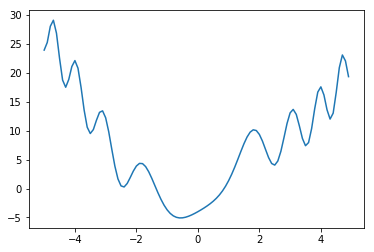

In [3]:
x = np.arange(-5, 5, 0.1)
y = any_function(x)

curveFigure = plt.figure()
plt.plot(x,y, figure = curveFigure)
plt.show()

Next, we need to find the deviation. A very simple and popular method is using [symmetric difference](https://en.wikipedia.org/wiki/Numerical_differentiation).

In [4]:
@np.vectorize
def numerical_derivative(x, f, h = 0.001):
    return (f(x+h) - f(x-h))/(2.0*h)

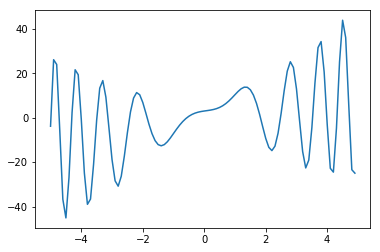

In [5]:
ytick = numerical_derivative(x, any_function)

plt.plot(x,ytick)
plt.show()

Now, we look for an $x$ for which $f'(x) = 0$. Seems like a difficult function to optimize since there are many values where this is the case.

For starters we can choose one point randomly, say $x = 3$, and start our gradient descend - basically we move $x$ to the negative gradient, only scaled by some 'rate' = $\mu$, i.e. $x_{\mathtt{new}} = x_{\mathtt{old}} - \mu * f'(x_{\mathtt{old}})$.

Furthermore, since $f'(x_1)$ is basically the slope of the tangent at $(x_1,y_1)$ we simply can draw it by using the equation $y = f'(x_1)\cdot(x - x_1) + y_1$

In [6]:
@np.vectorize
def tangent(x, x_p, any_function):
    y_p = any_function(x_p)
    m = numerical_derivative(x_p, any_function)
    y = m*(x - x_p) + y_p
    return y

#tangent([min(x), max(x)], xn, any_function)

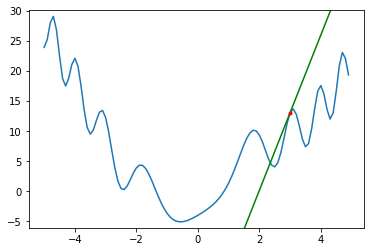

In [7]:
xn = 3
mu = 0.2

x_range = [min(x), max(x)]
y_range = tangent(x_range, xn, any_function)

plt.plot(x,y)
plt.plot(x_range, y_range, '-g')
plt.plot(xn, any_function(xn), '.r')
plt.ylim(min(y)-1, max(y)+1)
plt.show()

xn: 0.415843, f(xn) = -2.555534, f'(xn) = 4.148432
mu = 0.200000


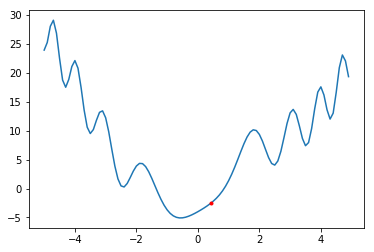

In [8]:
#mu = 0.9*mu
xnew = xn - mu * numerical_derivative(xn, any_function)
xn = xnew

print 'xn: %f, f(xn) = %f, f\'(xn) = %f' % (xn, any_function(xn), numerical_derivative(xn, any_function))
print 'mu = %f' % (mu)
plt.plot(x,y)
plt.plot(xn, any_function(xn), '.r')
plt.show()
# TODO: animate!

This example shows very nicely that altought we are close at finding the minimum we still have trouble to converge. This is due to the fixed learning rate. Hence, it is sensible to reduce the learning rate with time, e.g. by using exponetial decay $\mu = \mu_0*e^{-kt}$ ([see for others](http://cs231n.github.io/neural-networks-3/#anneal)).

In [15]:
def decay_exp(mu_0, t, k):
    return mu_0 * np.exp(-k*t)


def optimize_simple(f, x, mu, mudecay = decay_exp, k = 1, maxiter = 1000, eps = 0.001):
    y = f(x)
    i = 1
    yn = np.inf
    
    xhist = [x]
    yhist = [y]
    gradhist = [np.inf]
    
    mu_act = mudecay(mu, 0, k)
    while (not np.isclose(y, yn)) and (i < maxiter):
        y = yn
        ftick_x = numerical_derivative(x, f)
        x = x - mu_act * ftick_x
        yn = f(x)
        
        xhist.append(x)
        yhist.append(yn)
        gradhist.append(ftick_x)
        
        mu_act = mudecay(mu, i, k)
        i += 1
    
    
   
    return xhist, yhist, gradhist
    

15


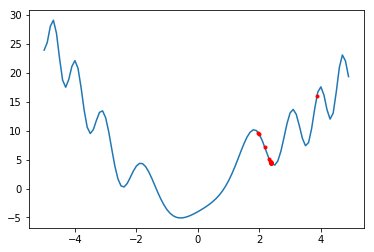

In [17]:
plt.plot(x,y)
xhist, yhist, gradhist = optimize_simple(any_function, 2, 0.2)
print len(xhist)
plt.plot(xhist, yhist, '.r')
    
plt.show()

In [24]:
@interact(x_in = (-4, 4, 0.1), mu = (0.01, 1, 0.01), k = (0.01, 5, 0.01))
def interactive_optim(x_in, mu, k):
    xhist, yhist, gradhist = optimize_simple(any_function, x_in, mu, k=k)
    xx = np.arange(min(xhist), max(xhist), 0.01)
    yy = any_function(xx)
    print len(xhist)
    plt.plot(xx,yy)
    plt.plot(xhist, yhist, '.r')    
    plt.show()


## Linear Regression Example

A simple Linear Regression based on Least Squares is usually solved by  $\mathbf{w} = (\mathbf{X}\mathbf{X}^T)^{-1}\mathbf{X}\hat{y}$ - i.e. it requires (relatively) expensive operation like matrix multiplication and matrix inverse. Sometimes the data is large and using linear algebra is simply not possible.

Gradiens come to help! By using Gradient Descent on the Squared Loss $E = \frac{1}{2}\sum\limits_{\mathbf{x}_i \in \mathbf{X}} (f(\mathbf{x}_i) - y)^2$ we may be able to find hopefully the right weights. 

The derivative of $E$ with respect to a 'weight' $w_i$ in $f(\cdot)$ is $ E'_{w_i} = \frac{dE}{dw_i}$


## Notes

An alternative approach is to comptue the gradient using [Automatic Differentiation](https://pypi.python.org/pypi/ad)